<a href="https://colab.research.google.com/github/andandandand/computer-vision-dsr/blob/main/planet_images_download_and_generate_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# we use the data repository in fastai to obtain a sample of satellite images of the Amazon
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [8]:
from fastai.vision.all import *
untar_data(URLs.PLANET_SAMPLE)

Path('/root/.fastai/data/planet_sample')

In [9]:
# this is the default destination of data downloaded with untar_data
# ~ is shorthand for '/root'
!ls ~/.fastai/data/

planet_sample


In [10]:
# me move the folder to Google Drive
!mv ~/.fastai/data/planet_sample 'gdrive/My Drive/planet_amazon_images'

mv: inter-device move failed: '/root/.fastai/data/planet_sample' to 'gdrive/My Drive/planet_amazon_images/planet_sample'; unable to remove target: Directory not empty


In [11]:
# check the contents of the new destination
!ls 'gdrive/My Drive/planet_amazon_images/planet_sample'

labels.csv  planet_amazon_image_embeddings.pickle  train


In [12]:
# number of images that we have in the train folder
len(os.listdir('gdrive/My Drive/planet_amazon_images/planet_sample/train'))

1000

In [13]:
# shorthand to access the path (we will be using it more)
image_path = Path('gdrive/My Drive/planet_amazon_images/planet_sample/train')

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# https://github.com/christiansafka/img2vec
class Img2Vec():

    def __init__(self, cuda=False, model='resnet-34', layer='default', layer_output_size=512):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model
        
        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Scale((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

        if self.model_name == 'alexnet':
            my_embedding = torch.zeros(1, self.layer_output_size)
        else:
            my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

        def copy_data(m, i, o):
            my_embedding.copy_(o.data)

        h = self.extraction_layer.register_forward_hook(copy_data)
        h_x = self.model(image)
        h.remove()

        if tensor:
            return my_embedding
        else:
            if self.model_name == 'alexnet':
                return my_embedding.numpy()[0, :]
            else:
                return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """
        if model_name == 'resnet-34':
            model = models.resnet34(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)


In [16]:
from PIL import Image
import skimage.io as io

# sample usage of get_vector, images should be passed as PIL
imag = Image.fromarray(io.imread(image_path / os.listdir(image_path)[0]))

img2vec = Img2Vec()
img2vec.get_vec(imag)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


array([1.38327754e+00, 1.01696566e-01, 0.00000000e+00, 5.06402217e-02, 8.43928084e-02, 0.00000000e+00, 0.00000000e+00, 6.13307990e-02, 2.70299613e-01, 3.01384002e-01, 2.63961017e-01, 3.41003686e-01,
       1.21724933e-01, 0.00000000e+00, 1.20755267e+00, 8.76283467e-01, 7.22257793e-01, 5.35469890e-01, 3.98229241e-01, 3.23574357e-02, 2.20979095e+00, 9.92121398e-02, 1.80686578e-01, 3.66064489e-01,
       6.58304393e-01, 1.04083428e-02, 4.91487861e-01, 2.09733918e-01, 1.08646259e-01, 1.52847022e-01, 2.35268280e-01, 8.55656862e-02, 1.16056003e-01, 9.35939848e-02, 4.70639378e-01, 1.17807472e+00,
       1.80493575e-02, 5.82767785e-01, 4.75097865e-01, 2.15780959e-01, 4.12872076e-01, 3.94438393e-02, 2.95365930e-01, 7.78708160e-01, 5.17580330e-01, 3.92638564e-01, 8.88338834e-02, 3.84919755e-02,
       1.59123614e-01, 7.86830336e-02, 2.14148343e-01, 1.10828295e-01, 8.24701972e-04, 1.50999650e-01, 2.55103230e-01, 3.73217016e-02, 3.10753733e-01, 2.38810253e+00, 1.55418301e+00, 2.55164236e-01,
     

In [17]:
# sample usage of img2vec in a pair of images 
a_imag = Image.fromarray(io.imread(image_path / os.listdir(image_path)[10]))
b_imag = Image.fromarray(io.imread(image_path / os.listdir(image_path)[20]))

a_vec = img2vec.get_vec(a_imag)
b_vec = img2vec.get_vec(b_imag)

In [18]:
from numpy import dot
from numpy.linalg import norm
import numpy as np

# this metrics characterizes the similarity of our embeddings 
def cosine_similarity(a, b):
  return(np.inner(a,b) / (norm(a) * norm(b)))

In [19]:
import matplotlib.pyplot as plt
#function to visualize a pair of images

def show_pair(path_a, path_b):
  arr_a = io.imread(path_a)
  arr_b = io.imread(path_b)

  plt.figure(figsize=(15, 20))

  plt.subplot(121)
  plt.imshow(arr_a)

  plt.subplot(122)
  plt.imshow(arr_b)

  plt.show()

In [20]:
# we create this list to iterate through the files in the folder
image_list = os.listdir(image_path)

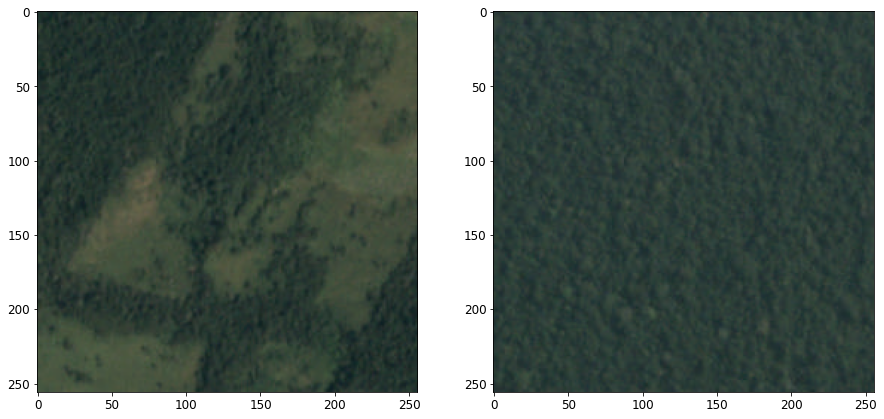

Cosine similarity = 0.4643


In [21]:

show_pair(image_path / image_list[10], image_path / image_list[20])
print('Cosine similarity = {:.4f}'.format(cosine_similarity(a_vec, b_vec)))

In [24]:

# we create an embeddings dictionary where the image name is the key 
# (this will take a couple of minutes to run)
embeddings_dict = {}
for imag in image_list:
  vector = img2vec.get_vec(Image.fromarray(io.imread(image_path / imag)))
  embeddings_dict[imag] = vector


In [25]:

# we will store the embeddings in the parent of the images folder
image_path.parent

Path('gdrive/My Drive/planet_amazon_images/planet_sample')

In [26]:
# save the dictionary to pickle
import pickle

with open(image_path.parent / 'planet_amazon_image_embeddings.pickle', 'wb') as handle:
    pickle.dump(embeddings_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(image_path.parent / 'planet_amazon_image_embeddings.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(embeddings_dict.keys() == b.keys())

True
